# DBScan

This example derived from <a href="https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py">Demo of DBSCAN clustering algorithm</a>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Set max rows and columns displayed in jupyter
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

#the following gives access to utils folder
#where utils package stores shared code
import os
import sys
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.getcwd(),
                  os.pardir)
)

#only add it once
if (PROJECT_ROOT not in sys.path):
    sys.path.append(PROJECT_ROOT)

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Constants

In [10]:
NSAMPLES=750

#Its hard to choose this one, without specialized knowledge choose 2*(numb_features+1)
THIS_MANY_CLOSEST_POINTS = 6

CENTERS_SEPERATED = [[1, 1], [-1, -1], [1, -1]]
CENTERS_OVERLAPPING = [[1, 1], [-1, -1], [1, -1]]

# Generate a dataset

In [79]:
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=NSAMPLES, centers=centers, cluster_std=.4, random_state=0
)

X = StandardScaler().fit_transform(X)


# Calculate eps
We do this in 2 steps<br>
1. Calculate the distances to THIS_MANY_CLOSEST_POINTS for every point in the dataset, then sort the results in descending order. Some of these points will be in a high density area (core and non-core points), so the average THIS_MANY_CLOSEST_POINTS distances will be smaller, others will be in a low density area (outliers), so the average THIS_MANY_CLOSEST_POINTS will be larger<br>
2. Find where the average distances starts growing the fastest.  Draw a vertical line through this point.  ANy eps to the left is a distance large enough that it risks erroneously merging distinct clusters together.


In [124]:
from sklearn.neighbors import NearestNeighbors
import plotly.express as px


# X_embedded is your data
nbrs = NearestNeighbors(n_neighbors=THIS_MANY_CLOSEST_POINTS ).fit(X)
distances, indices = nbrs.kneighbors(X)
distance_descending = sorted(distances[:,THIS_MANY_CLOSEST_POINTS-1], reverse=True);
# px.line(x=list(range(1,len(distance_descending )+1)),y= distance_descending )

In [125]:
#for every one of the 750 points, we are finding the 6 closest neighbors
distances.shape

(750, 6)

In [115]:
#install if you do not have it already
# !conda install -c conda-forge kneed -y

## Automate eps search with kneed
Parameters defined <a href="https://kneed.readthedocs.io/en/stable/parameters.html#curve">here</a><br>
Given x and y arrays, kneed attempts to identify the knee/elbow point of a line fit to the data. <mark>The knee/elbow is defined as the point of the line with maximum curvature. 

In [116]:
from kneed import KneeLocator
kneedle = KneeLocator(range(1,len(X)+1),  #x values
                      distance_descending, # y values
                      S=2.0, #sensitivity
                      curve="convex", 
                      direction="decreasing") #parameter from figure

The best eps=0.24068144123550458


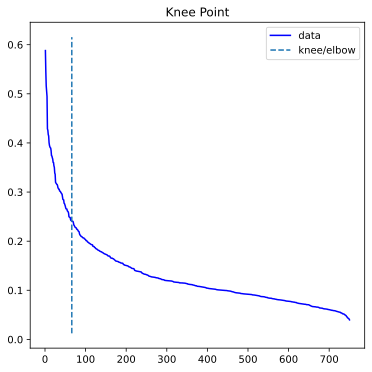

In [117]:
kneedle.plot_knee()

# kneedle.elbow
# kneedle.knee
eps=kneedle.knee_y  # optimum value for eps
print(f'The best eps={eps}')

# DBScan
eps calculated above<br>
<mark>what about min_samples?  a rule of thumb is 2*(number of features+1) unless you have specialized domain knowledge that differs

In [122]:
db = DBSCAN(eps=eps, min_samples=THIS_MANY_CLOSEST_POINTS).fit(X)

In [119]:
#cluster labels for dataset
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [120]:
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 1
Estimated number of noise points: 0


<AxesSubplot:>

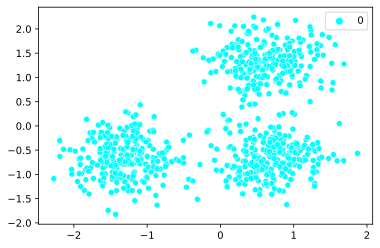

In [121]:
colors1 = {-1:"brown",
            0:"cyan",
           1:"orange", 
           2:"purple",
           3:"green",
          4:"yellow",
          5:"red",
          6:"blue"}
sns.scatterplot(data=X, x=X[:,0], y=X[:,1], hue=labels, palette=colors1)

# Sounds great right, try it with overlapping centers (), In section 3 above change cluster_std from .4 to .5

This makes it so cluster points will get a little closer to each other, in fact they get so close that core points let all the clusters connect with one another.  Boom one big cluster<br>
DBScan works great as long as there is not any cluster overlap.  When there is the algorithm starts to lose the ability to distinguish between clusters